<a href="https://colab.research.google.com/github/alexchilton/CAS_Project/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import libraries

In [1]:
%pip install tqdn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
from tqdm import tqdm

import tensorflow as tf

# 2. Paths and constants

In [3]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
# For Colab only_move to function file directory, load and go back to content /drive
%cd /content/drive/MyDrive/CAS_AML/function_files
import functions_m1_m2
%cd /content/drive

/content/drive/MyDrive/CAS_AML/function_files
/content/drive


In [5]:
DIR_TRAIN = '/content/drive/MyDrive/CAS_AML/datasets/fruits/train'
DIR_TEST = '/content/drive/MyDrive/CAS_AML/datasets/fruits/test'
DIR_VALIDATION = '/content/drive/MyDrive/CAS_AML/datasets/fruits/validation'
OUTPUT_DIR = '/content/drive/MyDrive/CAS_AML/outputs'

MODEL_LOCATION = '/content/drive/MyDrive/CAS_AML/models'

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 3. dataset

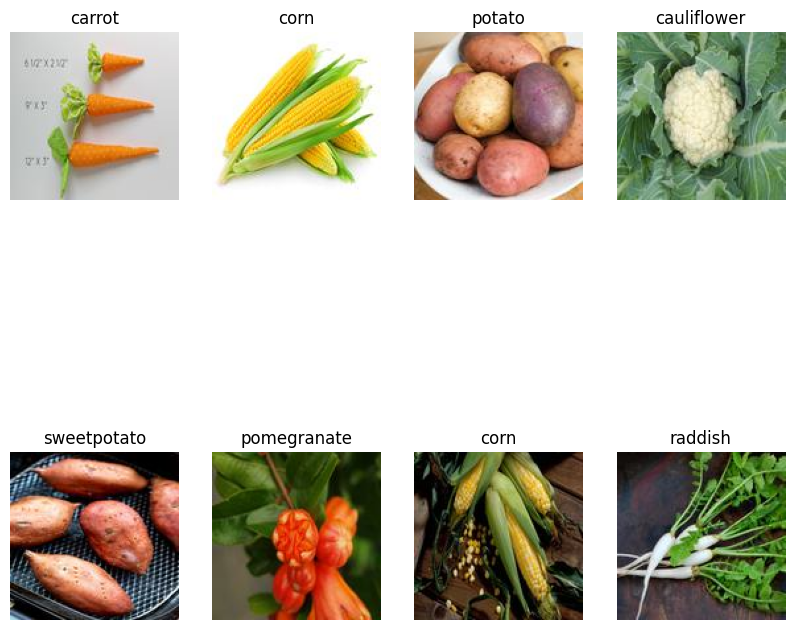

In [5]:
functions_m1_m2.show_random_images(DIR_TRAIN, 8)

# 4. Transfer learning

## 4.1 ResNet50

In [6]:
from tensorflow.keras.applications import resnet50

In [7]:
model_rn50=tf.keras.applications.ResNet50(weights='imagenet')

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
def preprocess_for_resnet50(image, label):
    image = resnet50.preprocess_input(image)
    return image, label

In [9]:
def get_preprocessed_dataset_resnet50(path, batch_size=32):
    loader = functions_m1_m2.ImageLoader(width=224, height=224)  # Adjust size based on model
    dataset = loader.create_dataset(path, batch_size=batch_size)
    dataset = dataset.map(preprocess_for_resnet50,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

In [10]:
train_set = get_preprocessed_dataset_resnet50(path=DIR_TRAIN, batch_size=32)

In [11]:
random_images, random_labels = functions_m1_m2.select_random_images(train_set, num_images=5)

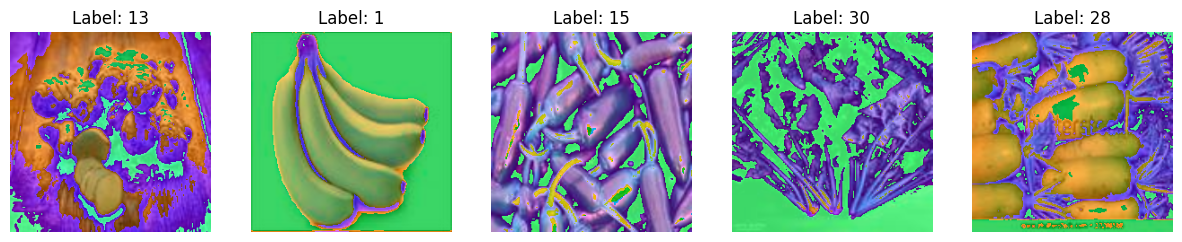

In [13]:
functions_m1_m2.visualize_images(random_images, random_labels)


In [14]:
Y_proba=model_rn50.predict(random_images)
Y_proba.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


(5, 1000)

In [20]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)

num_images = min(len(top_K), len(train_set))  # Adjust to the smaller length
for image_index in range(num_images):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f" {class_id} - {name:12s} {y_proba:.2%}")

Image #0
 n03729826 - matchstick   8.82%
 n03196217 - digital_clock 4.89%
 n01930112 - nematode     3.32%
Image #1
 n03729826 - matchstick   9.11%
 n06359193 - web_site     4.88%
 n04404412 - television   3.82%
Image #2
 n03729826 - matchstick   9.65%
 n04286575 - spotlight    2.67%
 n09229709 - bubble       2.51%
Image #3
 n03729826 - matchstick   7.75%
 n03196217 - digital_clock 6.53%
 n04286575 - spotlight    3.51%
Image #4
 n03729826 - matchstick   5.62%
 n03196217 - digital_clock 4.83%
 n04404412 - television   4.54%


Predictions are off as the categiries we're trying to predict are not classes of Imagenet. We will therefore use the pre-trained model but re-train the top layer to our classes.

## 4.2 Pre-trained ResNet50 for transfer learning